# Project Objective
The purpose of this project is to determine which customers are potential churn customers between Q3 to Q4 2021 and then to rank these customers from highest priority to lowest priority. The dataset provided contains field regarding contract date, contract value, expiry date, and customer region. There is no information about customer churn therefore it needs to be deduced from the data provided. The ranking needs to be defined as well based on the data.

The dataset can be found here: https://www.kaggle.com/datasets/kagglemaster95/customer-churn-data


In [1]:
# import relevant modules
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import datetime
from dateutil.relativedelta import *
# mount google drive to download datasets
from google.colab import drive
drive.mount('/content/drive')


from matplotlib import gridspec
import matplotlib.pyplot as plt
import plotnine as p9

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
from sklearn.ensemble import RandomForestClassifier
from sklearn_extra.cluster import KMedoids
from sklearn.metrics import silhouette_samples, silhouette_score

import umap.umap_ as umap
import plotly
import plotly.graph_objects as go

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
# import contracts and accounts dataset for analysis into dataframes via pandas
adf = pd.read_csv('/content/drive/MyDrive/CSCA_5632_FINAL/accounts.csv')
cdf = pd.read_csv('/content/drive/MyDrive/CSCA_5632_FINAL/contracts.csv')


# 1. Data Exploration and Insights



In [3]:
# no null values in accounts
adf.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3000 entries, 0 to 2999
Data columns (total 3 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   accountID        3000 non-null   object
 1   region           3000 non-null   object
 2   partnerInvolved  3000 non-null   object
dtypes: object(3)
memory usage: 70.4+ KB


In [4]:
# 3000 unique accounts
adf.accountID.nunique()

3000

In [ ]:
adf.head()

,accountID,region,partnerInvolved
0,wod6kb,North America,Yes
1,nikq3g,Africa,Yes
2,bobn76,EMEA,No
3,w17pof,EMEA,No
4,5f4fby,EMEA,No


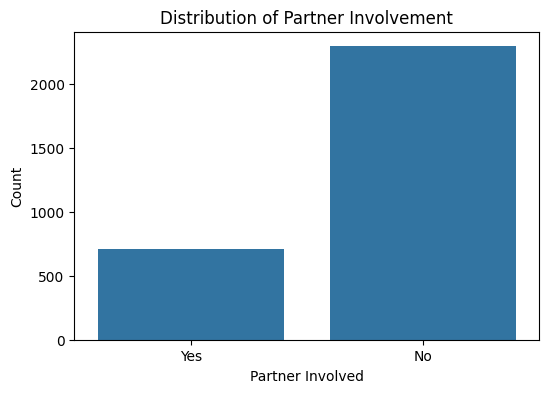

,count
partnerInvolved,
No,2294
Yes,706


In [5]:
# In most accounts there is no partner involved
plt.figure(figsize=(6, 4))
sns.countplot(x='partnerInvolved', data=adf)
plt.title('Distribution of Partner Involvement')
plt.xlabel('Partner Involved')
plt.ylabel('Count')
plt.show()

adf.partnerInvolved.value_counts()

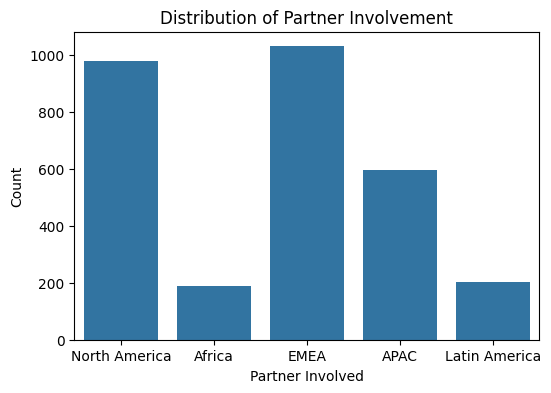

,count
region,
EMEA,1031
North America,981
APAC,596
Latin America,202
Africa,190


In [6]:
# most clients are from EMEA and North America
plt.figure(figsize=(6, 4))
sns.countplot(x='region', data=adf)
plt.title('Distribution of Partner Involvement')
plt.xlabel('Partner Involved')
plt.ylabel('Count')
plt.show()

adf.region.value_counts()

In [7]:
# lets look at the contract dataset
# there are 278 missing payment dates
cdf.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7628 entries, 0 to 7627
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   closingDate     7628 non-null   object 
 1   contractSize    7628 non-null   float64
 2   contractLength  7628 non-null   int64  
 3   contractID      7628 non-null   object 
 4   paymentDate     7350 non-null   object 
dtypes: float64(1), int64(1), object(3)
memory usage: 298.1+ KB


In [8]:
# there is no explicit join between contracts and accounts however the contract column looks like a derived column made of three components separated by "-"
cdf.head()

,closingDate,contractSize,contractLength,contractID,paymentDate
0,2013/01/01,90.0,2,OLV-julh8a-0001,2013/03/28
1,2013/01/01,195.0,1,OLV-ujmvzq-0001,2013/04/21
2,2013/01/01,110.0,2,OLV-0ar1mc-0001,2013/03/23
3,2013/01/02,55.0,3,OLV-13y3ml-0001,2013/03/22
4,2013/01/03,275.0,2,OLV-lcssnx-0001,2013/04/20


In [9]:
# lets check what does each components is
cdf[['key1','key2','key3']]=cdf.contractID.str.split('-',expand=True)

In [10]:
cdf.key1.value_counts()

,count
key1,
OLV,7628


In [11]:
# second component is made of different values
cdf.key2.value_counts()

,count
key2,
4qvbld,8
8majk6,7
u80esf,7
g3shve,7
ge95xg,7
...,...
wmqouc,1
wted0t,1
xz3m86,1


In [12]:
# second component has as many unique values as the account ID in the accounts table
cdf.key2.nunique()

3000

In [13]:
# second component is the accountid and can be used to join contract table with account table
cdf.key2.isin(adf.accountID).value_counts()

,count
key2,
True,7628


In [14]:
# third component is made of different numbers
cdf.key3.value_counts()

,count
key3,
0001,3000
0002,2186
0003,1382
0004,706
0005,279
0006,67
0007,7
0008,1


In [15]:
# When sorted by account id component 3 is the number of contract by the account
cdf.sort_values(by=['key2','key3'])

,closingDate,contractSize,contractLength,contractID,paymentDate,key1,key2,key3
582,2014/05/03,95.0,1,OLV-00dkoj-0001,2014/07/22,OLV,00dkoj,0001
1173,2015/05/03,182.0,2,OLV-00dkoj-0002,2015/08/02,OLV,00dkoj,0002
2850,2017/05/02,236.0,2,OLV-00dkoj-0003,2017/07/27,OLV,00dkoj,0003
5147,2019/05/02,508.0,2,OLV-00dkoj-0004,2019/07/29,OLV,00dkoj,0004
7445,2021/05/01,754.0,3,OLV-00dkoj-0005,NaN,OLV,00dkoj,0005
...,...,...,...,...,...,...,...,...
4781,2019/01/22,70.0,2,OLV-zz5bex-0001,2019/04/28,OLV,zz5bex,0001
4162,2018/07/03,265.0,3,OLV-zzn203-0001,2018/11/06,OLV,zzn203,0001
2377,2016/11/06,165.0,1,OLV-zzuoer-0001,2017/02/21,OLV,zzuoer,0001
3385,2017/11/06,192.0,1,OLV-zzuoer-0002,2018/02/25,OLV,zzuoer,0002


In [16]:
# Now we will separate the contract id into its component keys
cdf.rename(columns={'key1':'Vendor','key2':'accountID','key3':'Occurence_no'},inplace=True)
cdf['Occurence_no']=cdf['Occurence_no'].astype(int)
cdf.head()

,closingDate,contractSize,contractLength,contractID,paymentDate,Vendor,accountID,Occurence_no
0,2013/01/01,90.0,2,OLV-julh8a-0001,2013/03/28,OLV,julh8a,1
1,2013/01/01,195.0,1,OLV-ujmvzq-0001,2013/04/21,OLV,ujmvzq,1
2,2013/01/01,110.0,2,OLV-0ar1mc-0001,2013/03/23,OLV,0ar1mc,1
3,2013/01/02,55.0,3,OLV-13y3ml-0001,2013/03/22,OLV,13y3ml,1
4,2013/01/03,275.0,2,OLV-lcssnx-0001,2013/04/20,OLV,lcssnx,1


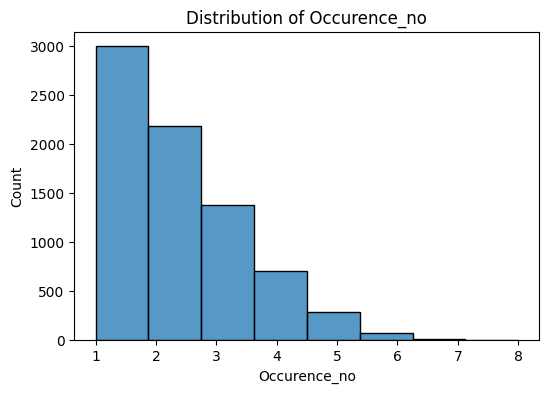

,Occurence_no
count,7628.000000
mean,2.123230
std,1.194595
min,1.000000
25%,1.000000
50%,2.000000
75%,3.000000
max,8.000000


In [17]:
plt.figure(figsize=(6, 4))
sns.histplot(x='Occurence_no', data=cdf, bins=8)
plt.title('Distribution of Occurence_no')
plt.xlabel('Occurence_no')
plt.ylabel('Count')
plt.show()

cdf.Occurence_no.describe()

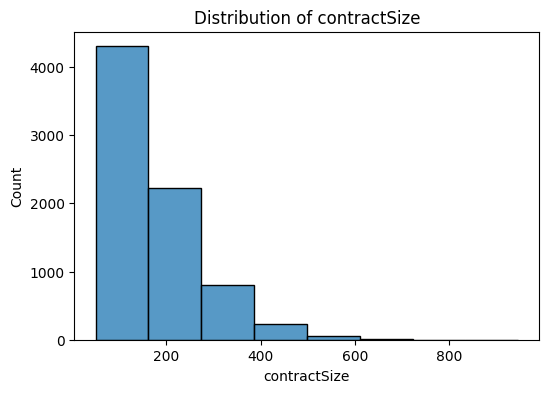

,contractSize
count,7628.000000
mean,168.825773
std,100.826310
min,50.000000
25%,92.000000
50%,145.000000
75%,220.000000
max,946.000000


In [18]:
plt.figure(figsize=(6, 4))
sns.histplot(x='contractSize', data=cdf, bins=8)
plt.title('Distribution of contractSize')
plt.xlabel('contractSize')
plt.ylabel('Count')
plt.show()

cdf.contractSize.describe()

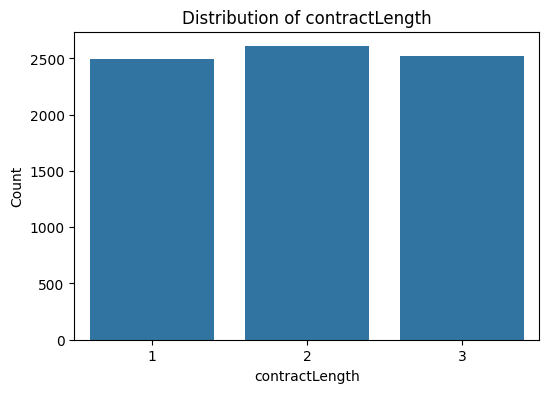

,contractLength
count,7628.000000
mean,2.003802
std,0.811360
min,1.000000
25%,1.000000
50%,2.000000
75%,3.000000
max,3.000000


In [19]:
plt.figure(figsize=(6, 4))
sns.countplot(x='contractLength', data=cdf)
plt.title('Distribution of contractLength')
plt.xlabel('contractLength')
plt.ylabel('Count')
plt.show()

cdf.contractLength.describe()

In [20]:
cdf['closingDate'] = pd.to_datetime(cdf['closingDate'])
cdf['paymentDate'] = pd.to_datetime(cdf['paymentDate'])

In [21]:
cdf['closingDate'].describe()

,closingDate
count,7628
mean,2017-12-15 14:59:31.683272192
min,2013-01-01 00:00:00
25%,2016-04-27 00:00:00
50%,2018-03-24 00:00:00
75%,2019-10-11 00:00:00
max,2021-06-30 00:00:00


In [22]:
cdf['paymentDate'].describe()

,paymentDate
count,7350
mean,2018-02-01 11:16:06.857142784
min,2013-03-16 00:00:00
25%,2016-07-06 06:00:00
50%,2018-05-16 00:00:00
75%,2019-11-15 00:00:00
max,2021-06-30 00:00:00


In [23]:
# Checking paymentdate for contract initiated after 2021
# All null payment dates are aasigned to contracts that have contract expiry date after the year 2021 starting with 2022.
# the data after Q4 2021 is out of scope
sd=cdf[cdf['closingDate'].dt.year >= 2021]
sd[sd['paymentDate'].isna()]

,closingDate,contractSize,contractLength,contractID,paymentDate,Vendor,accountID,Occurence_no
7248,2021-02-21,272.0,2,OLV-1stu3q-0002,NaT,OLV,1stu3q,2
7266,2021-02-26,348.0,2,OLV-11u7p7-0003,NaT,OLV,11u7p7,3
7270,2021-02-27,100.0,1,OLV-lmxmzo-0004,NaT,OLV,lmxmzo,4
7286,2021-03-05,322.0,3,OLV-2c6ccs-0003,NaT,OLV,2c6ccs,3
7287,2021-03-05,228.0,3,OLV-erwp16-0004,NaT,OLV,erwp16,4
...,...,...,...,...,...,...,...,...
7623,2021-06-29,357.0,3,OLV-p3nwky-0006,NaT,OLV,p3nwky,6
7624,2021-06-29,175.0,1,OLV-p009ge-0004,NaT,OLV,p009ge,4
7625,2021-06-30,203.0,1,OLV-am5nm2-0004,NaT,OLV,am5nm2,4
7626,2021-06-30,154.0,1,OLV-02k5gq-0004,NaT,OLV,02k5gq,4


## Summary Data Exploration and insights

- In the dataset column Contract ID a composite key made of vendorID, AccountID, and the number of the contract for a particular account ID. This column is deconstructed into three columns vendor ID, Account ID, and Occurrence respectively.

- After exploration we can define the column as such:

>> closingDate: The date contract is finalize between company or vendor and customer.

>> contractsize: The value of the contract in some amount which is not known but does not matter for our analysis.

>> ContractLength: this is the length of contract in years.

>> PaymentDate: the date of payment customer made to company for the contract.

>> ContractID: It is the composite primary key for each contract in the contract table that is made up of company initials + accountID + contract sequence.

>> AccountID: Primary key of the account table.

>> Region: Geographic region the account belongs to.

>> PartnerInvolved: this is binary field (Yes/No) probably meaning if there is another partner who helped get the contract.

# 2. Data prepartion and deriving features

In [24]:
# Contract end data is closing date plus the length of contract should equal to when the contract ends
cdf['contract_expiry_date'] = cdf.apply(lambda row: row['closingDate'] + relativedelta(years=row['contractLength']), axis=1)

In [25]:
cdf.head()

,closingDate,contractSize,contractLength,contractID,paymentDate,Vendor,accountID,Occurence_no,contract_expiry_date
0,2013-01-01,90.0,2,OLV-julh8a-0001,2013-03-28,OLV,julh8a,1,2015-01-01
1,2013-01-01,195.0,1,OLV-ujmvzq-0001,2013-04-21,OLV,ujmvzq,1,2014-01-01
2,2013-01-01,110.0,2,OLV-0ar1mc-0001,2013-03-23,OLV,0ar1mc,1,2015-01-01
3,2013-01-02,55.0,3,OLV-13y3ml-0001,2013-03-22,OLV,13y3ml,1,2016-01-02
4,2013-01-03,275.0,2,OLV-lcssnx-0001,2013-04-20,OLV,lcssnx,1,2015-01-03


In [26]:
cdf[cdf.paymentDate.isna()]

,closingDate,contractSize,contractLength,contractID,paymentDate,Vendor,accountID,Occurence_no,contract_expiry_date
7248,2021-02-21,272.0,2,OLV-1stu3q-0002,NaT,OLV,1stu3q,2,2023-02-21
7266,2021-02-26,348.0,2,OLV-11u7p7-0003,NaT,OLV,11u7p7,3,2023-02-26
7270,2021-02-27,100.0,1,OLV-lmxmzo-0004,NaT,OLV,lmxmzo,4,2022-02-27
7286,2021-03-05,322.0,3,OLV-2c6ccs-0003,NaT,OLV,2c6ccs,3,2024-03-05
7287,2021-03-05,228.0,3,OLV-erwp16-0004,NaT,OLV,erwp16,4,2024-03-05
...,...,...,...,...,...,...,...,...,...
7623,2021-06-29,357.0,3,OLV-p3nwky-0006,NaT,OLV,p3nwky,6,2024-06-29
7624,2021-06-29,175.0,1,OLV-p009ge-0004,NaT,OLV,p009ge,4,2022-06-29
7625,2021-06-30,203.0,1,OLV-am5nm2-0004,NaT,OLV,am5nm2,4,2022-06-30
7626,2021-06-30,154.0,1,OLV-02k5gq-0004,NaT,OLV,02k5gq,4,2022-06-30


In [27]:
# All null payment dates are aasigned to contracts that have contract expiry date after the year 2021 starting with 2022.
# the data after Q4 2021 is out of scope
cdf.head(2)

,closingDate,contractSize,contractLength,contractID,paymentDate,Vendor,accountID,Occurence_no,contract_expiry_date
0,2013-01-01,90.0,2,OLV-julh8a-0001,2013-03-28,OLV,julh8a,1,2015-01-01
1,2013-01-01,195.0,1,OLV-ujmvzq-0001,2013-04-21,OLV,ujmvzq,1,2014-01-01


In [28]:
# Converting paymentdate to datetime datatype to find length_to_pay feature
cdf['paymentDate'] = pd.to_datetime(cdf['paymentDate'])

In [29]:
# defining length to pay feature
cdf['length_to_pay']=(cdf['paymentDate']-cdf['closingDate'])

In [30]:
cdf.head()

,closingDate,contractSize,contractLength,contractID,paymentDate,Vendor,accountID,Occurence_no,contract_expiry_date,length_to_pay
0,2013-01-01,90.0,2,OLV-julh8a-0001,2013-03-28,OLV,julh8a,1,2015-01-01,86 days
1,2013-01-01,195.0,1,OLV-ujmvzq-0001,2013-04-21,OLV,ujmvzq,1,2014-01-01,110 days
2,2013-01-01,110.0,2,OLV-0ar1mc-0001,2013-03-23,OLV,0ar1mc,1,2015-01-01,81 days
3,2013-01-02,55.0,3,OLV-13y3ml-0001,2013-03-22,OLV,13y3ml,1,2016-01-02,79 days
4,2013-01-03,275.0,2,OLV-lcssnx-0001,2013-04-20,OLV,lcssnx,1,2015-01-03,107 days


In [31]:
cdf.columns

Index(['closingDate', 'contractSize', 'contractLength', 'contractID',
       'paymentDate', 'Vendor', 'accountID', 'Occurence_no',
       'contract_expiry_date', 'length_to_pay'],
      dtype='object')

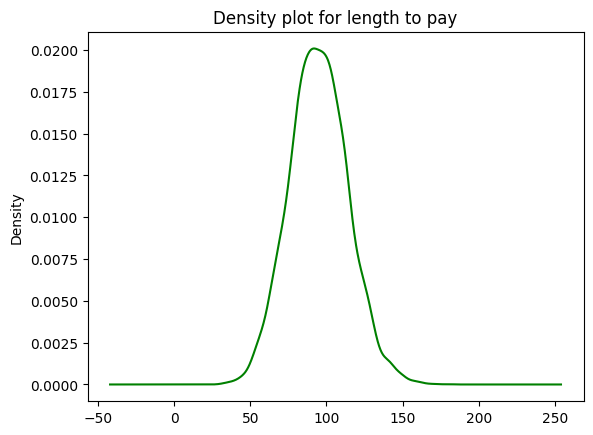

In [34]:
cdf['length_to_pay']=pd.to_timedelta(cdf.length_to_pay, errors='coerce').dt.days
# Densityplot to see the distribution of length_to_pay feature
cdf.length_to_pay.plot.density(color='green')
plt.title('Density plot for length to pay')
plt.show()

In [35]:
#distribution of length to pay is normal
cdf.length_to_pay.describe()

,length_to_pay
count,7350.000000
mean,94.948027
std,19.245208
min,32.000000
25%,82.000000
50%,95.000000
75%,108.000000
max,180.000000


In [36]:
# Function to define feature gap between deal. Gap between deal is the calculation of the difference of days between the expiry date of a contract
# and renewal of the next contract for a customer

def gap_between_deal(df,fulldf):
  acc_id=df['accountID']
  new_deal_date=df['closingDate']
  occ_no=df['Occurence_no']
  filtered_df=fulldf[fulldf['accountID']==acc_id]
  if occ_no > 1:
    tempdf=filtered_df[filtered_df['Occurence_no']==occ_no-1]
    gap_days=(new_deal_date - tempdf['contract_expiry_date'].iloc[0]).days

  else:
    gap_days=99999999999
  return gap_days


In [37]:
# Creating gp_between_deals feature
cdf['gap_between_deals'] =cdf.apply(gap_between_deal,fulldf=cdf,axis=1)

In [38]:
cdf[cdf['Occurence_no']>1].head(2)

,closingDate,contractSize,contractLength,contractID,paymentDate,Vendor,accountID,Occurence_no,contract_expiry_date,length_to_pay,gap_between_deals
386,2014-01-01,252.0,2,OLV-ujmvzq-0002,2014-04-23,OLV,ujmvzq,2,2016-01-01,112.0,0
390,2014-01-03,75.0,2,OLV-llogub-0002,2014-04-05,OLV,llogub,2,2016-01-03,92.0,0


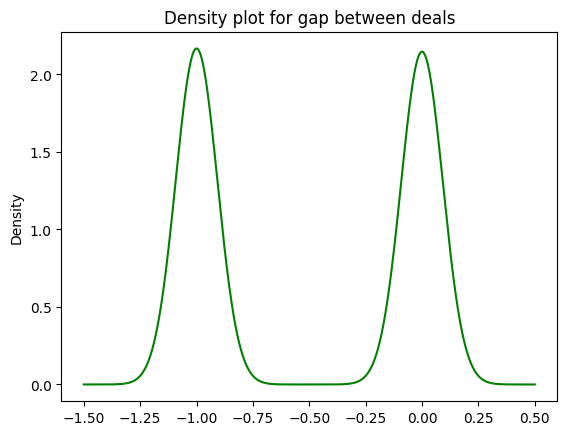

In [39]:
# Density plot to see the distribution of gap_between_deals
''' The values of gap_between_deal helps in defines the definition of Churn. If the a customer signs a new contract before or one day after the expiration of current contract
then the customer is not churn else it is a churned customer. '''
cdf[cdf['Occurence_no']>1].gap_between_deals.plot.density(color='green')
plt.title('Density plot for gap between deals')
plt.show()

In [40]:
cdf.gap_between_deals.unique()

array([99999999999,           0,          -1])

In [41]:
# checking max closing date
cdf['closingDate'].max()

Timestamp('2021-06-30 00:00:00')

In [42]:
# Determine max contact expiry date in the dateset
cdf[cdf['contract_expiry_date']==cdf['contract_expiry_date'].max()]

,closingDate,contractSize,contractLength,contractID,paymentDate,Vendor,accountID,Occurence_no,contract_expiry_date,length_to_pay,gap_between_deals
7623,2021-06-29,357.0,3,OLV-p3nwky-0006,NaT,OLV,p3nwky,6,2024-06-29,NaN,-1


In [43]:
# cutoffdate is the max closing date after this date there is no information of new contracts signed.
# therefore the contracts which expires before cutoff date can be determined whther they are renewed or not.
cutoffdate=cdf['closingDate'].max()+ datetime.timedelta(days=1)
cutoffdate

Timestamp('2021-07-01 00:00:00')

In [44]:
# Offset date is the last date of Q4 2021
offsetdate=cutoffdate + relativedelta(months=6)
offsetdate

Timestamp('2022-01-01 00:00:00')

In [45]:
cdf[cdf['contract_expiry_date']<=cdf['closingDate'].max()]['closingDate'].max()

Timestamp('2020-06-30 00:00:00')

In [46]:
cdf[cdf['contract_expiry_date']<=cdf['closingDate'].max()].shape

(5343, 11)

In [47]:
cdf[cdf['closingDate']==cdf['closingDate'].max()]

,closingDate,contractSize,contractLength,contractID,paymentDate,Vendor,accountID,Occurence_no,contract_expiry_date,length_to_pay,gap_between_deals
7625,2021-06-30,203.0,1,OLV-am5nm2-0004,NaT,OLV,am5nm2,4,2022-06-30,NaN,-1
7626,2021-06-30,154.0,1,OLV-02k5gq-0004,NaT,OLV,02k5gq,4,2022-06-30,NaN,-1
7627,2021-06-30,87.0,1,OLV-uvj5e3-0003,NaT,OLV,uvj5e3,3,2022-06-30,NaN,0


In [48]:
# Contracts expired after the cutoff date
cdf[cdf['closingDate']>=cdf[cdf['contract_expiry_date']<=cdf['closingDate'].max()]['closingDate'].max()]

,closingDate,contractSize,contractLength,contractID,paymentDate,Vendor,accountID,Occurence_no,contract_expiry_date,length_to_pay,gap_between_deals
6576,2020-06-30,175.0,3,OLV-79orxn-0005,2020-09-22,OLV,79orxn,5,2023-06-30,84.0,-1
6577,2020-06-30,75.0,1,OLV-uvj5e3-0002,2020-10-04,OLV,uvj5e3,2,2021-06-30,96.0,-1
6578,2020-07-01,183.0,2,OLV-7auyn4-0003,2020-09-03,OLV,7auyn4,3,2022-07-01,64.0,-1
6579,2020-07-01,161.0,2,OLV-bgjldf-0005,2020-10-20,OLV,bgjldf,5,2022-07-01,111.0,-1
6580,2020-07-01,87.0,1,OLV-ck8cqe-0003,2020-10-03,OLV,ck8cqe,3,2021-07-01,94.0,-1
...,...,...,...,...,...,...,...,...,...,...,...
7623,2021-06-29,357.0,3,OLV-p3nwky-0006,NaT,OLV,p3nwky,6,2024-06-29,NaN,-1
7624,2021-06-29,175.0,1,OLV-p009ge-0004,NaT,OLV,p009ge,4,2022-06-29,NaN,-1
7625,2021-06-30,203.0,1,OLV-am5nm2-0004,NaT,OLV,am5nm2,4,2022-06-30,NaN,-1
7626,2021-06-30,154.0,1,OLV-02k5gq-0004,NaT,OLV,02k5gq,4,2022-06-30,NaN,-1


In [49]:
cdf[cdf['contract_expiry_date']<=cdf['closingDate'].max()]['closingDate'].max()

Timestamp('2020-06-30 00:00:00')

In [50]:
cdf.shape

(7628, 11)

In [51]:
cdf[cdf['contract_expiry_date']>=offsetdate].shape

(1669, 11)

In [52]:
cdf[cdf['contract_expiry_date']>=offsetdate].isna().sum()

,0
closingDate,0
contractSize,0
contractLength,0
contractID,0
paymentDate,278
Vendor,0
accountID,0
Occurence_no,0
contract_expiry_date,0
length_to_pay,278


In [53]:
# Determining whether a contract will be renewed, not_renewed, unknown by analyzing whether a customer has renwed its contract on the expiry date
# or before the expiry date.
# A contract has been renewed, if that customer has initiated another contract in the dataset on the present contract expiry date or 1 day before expiry.
# If contract expiry date falls after the cutoff date then it cannot be determine whether the contract is renewed or not renewed
# because no data available
def determine_churn(d,present_day,wdf):
  ce_dt=d['contract_expiry_date']
  ce_bfdt=ce_dt - datetime.timedelta(days=1)
  ce_afdt=ce_dt + datetime.timedelta(days=1)
  cus=d['accountID']
  if ce_dt>present_day:
    res="unknown"
  else:
    cusdf=wdf[wdf['accountID']==cus]
    closingdt_lst = cusdf['closingDate'].tolist()
    if ce_dt in closingdt_lst or ce_afdt in closingdt_lst or ce_bfdt in closingdt_lst:
      res="renewed"
    else:
      res="not renewed"
  return res

In [54]:
# Merging the customers data and contracts data
mdf=pd.merge(cdf,adf,on='accountID',how='inner')

In [55]:
mdf.head()

,closingDate,contractSize,contractLength,contractID,paymentDate,Vendor,accountID,Occurence_no,contract_expiry_date,length_to_pay,gap_between_deals,region,partnerInvolved
0,2013-01-01,90.0,2,OLV-julh8a-0001,2013-03-28,OLV,julh8a,1,2015-01-01,86.0,99999999999,North America,No
1,2013-01-01,195.0,1,OLV-ujmvzq-0001,2013-04-21,OLV,ujmvzq,1,2014-01-01,110.0,99999999999,APAC,No
2,2013-01-01,110.0,2,OLV-0ar1mc-0001,2013-03-23,OLV,0ar1mc,1,2015-01-01,81.0,99999999999,EMEA,No
3,2013-01-02,55.0,3,OLV-13y3ml-0001,2013-03-22,OLV,13y3ml,1,2016-01-02,79.0,99999999999,APAC,No
4,2013-01-03,275.0,2,OLV-lcssnx-0001,2013-04-20,OLV,lcssnx,1,2015-01-03,107.0,99999999999,EMEA,No


In [56]:
# Determining if the contracts has been renewed, not renewed or unknown
mdf['is_renewal']=mdf.apply(determine_churn,present_day=cdf['closingDate'].max(),wdf=mdf,axis=1)

In [57]:
# Determining in which quarter of a year does the contracts fall
mdf['Quarter']=mdf['closingDate'].dt.quarter
mdf['Quarter']='Q'+mdf['Quarter'].astype(str)

In [58]:
# For predicting Renewal id column not required. gap between deals has been removed because this column won't be available in testdata.
mdf.drop(columns=['contractID','Vendor','gap_between_deals'],inplace=True)

In [59]:
mdf.shape

(7628, 12)

In [60]:
mdf.head(3)

,closingDate,contractSize,contractLength,paymentDate,accountID,Occurence_no,contract_expiry_date,length_to_pay,region,partnerInvolved,is_renewal,Quarter
0,2013-01-01,90.0,2,2013-03-28,julh8a,1,2015-01-01,86.0,North America,No,renewed,Q1
1,2013-01-01,195.0,1,2013-04-21,ujmvzq,1,2014-01-01,110.0,APAC,No,renewed,Q1
2,2013-01-01,110.0,2,2013-03-23,0ar1mc,1,2015-01-01,81.0,EMEA,No,renewed,Q1


In [61]:
# Distribution of Renewals.
mdf['is_renewal'].value_counts()

,count
is_renewal,
renewed,4626
unknown,2285
not renewed,717


In [62]:
# Transforming Categorical variable into one hot encoding by using dummies
tempdf=mdf.copy()
tempdf = pd.get_dummies(tempdf, columns = ['region', 'partnerInvolved','Quarter'])

In [63]:
# Splitting the train and test data
# testdata- Contracts For which it is not known whether it will be renewed or not. Contracts whose expiring date is after cutoff date
# and before offsetdate
# train data - Contracts for which renewal status is know. Contracts whose expiring date is before the cutoffdate(untill the last contract has been closed.)

testdataset=tempdf[(tempdf['contract_expiry_date']>=cutoffdate) & (tempdf['contract_expiry_date'] < offsetdate)]
traindataset=tempdf[tempdf['contract_expiry_date'] < cutoffdate]

In [64]:
traindataset['is_renewal'].value_counts()

,count
is_renewal,
renewed,4626
not renewed,717


In [65]:
traindataset.head(3)

,closingDate,contractSize,contractLength,paymentDate,accountID,Occurence_no,contract_expiry_date,length_to_pay,is_renewal,region_APAC,region_Africa,region_EMEA,region_Latin America,region_North America,partnerInvolved_No,partnerInvolved_Yes,Quarter_Q1,Quarter_Q2,Quarter_Q3,Quarter_Q4
0,2013-01-01,90.0,2,2013-03-28,julh8a,1,2015-01-01,86.0,renewed,False,False,False,False,True,True,False,True,False,False,False
1,2013-01-01,195.0,1,2013-04-21,ujmvzq,1,2014-01-01,110.0,renewed,True,False,False,False,False,True,False,True,False,False,False
2,2013-01-01,110.0,2,2013-03-23,0ar1mc,1,2015-01-01,81.0,renewed,False,False,True,False,False,True,False,True,False,False,False


In [66]:
testdataset.head(3)

,closingDate,contractSize,contractLength,paymentDate,accountID,Occurence_no,contract_expiry_date,length_to_pay,is_renewal,region_APAC,region_Africa,region_EMEA,region_Latin America,region_North America,partnerInvolved_No,partnerInvolved_Yes,Quarter_Q1,Quarter_Q2,Quarter_Q3,Quarter_Q4
4150,2018-07-01,148.0,3,2018-10-20,02k5gq,3,2021-07-01,111.0,unknown,True,False,False,False,False,False,True,False,False,True,False
4152,2018-07-01,257.0,3,2018-10-05,am5nm2,3,2021-07-01,96.0,unknown,True,False,False,False,False,False,True,False,False,True,False
4154,2018-07-02,128.0,3,2018-10-10,e0bgqm,3,2021-07-02,100.0,unknown,False,False,False,False,True,True,False,False,False,True,False


In [67]:
print(traindataset.shape)
print(testdataset.shape)

(5343, 20)
(616, 20)


In [68]:
#columns removed because dates has been transformed to new features and id doesnt hold value in classsification.
removal_cls=['closingDate','paymentDate','contract_expiry_date','accountID']

In [69]:
traincls=list(set(traindataset.columns).difference(set(removal_cls)))

In [70]:
# Checking colinearity
corr = traindataset.drop(columns = 	"is_renewal").loc[:, ~ traindataset.drop(columns = "is_renewal").columns.isin(removal_cls)].corr()
corr

,contractSize,contractLength,Occurence_no,length_to_pay,region_APAC,region_Africa,region_EMEA,region_Latin America,region_North America,partnerInvolved_No,partnerInvolved_Yes,Quarter_Q1,Quarter_Q2,Quarter_Q3,Quarter_Q4
contractSize,1.000000,-0.079231,0.410573,0.107476,-0.029562,-0.053285,0.034779,-0.066212,0.050146,-0.009587,0.009587,0.027077,-0.003229,0.004924,-0.029144
contractLength,-0.079231,1.000000,-0.141640,0.026533,0.014228,0.017950,-0.013594,0.005930,-0.010181,0.000061,-0.000061,0.013659,0.000472,-0.018208,0.002999
Occurence_no,0.410573,-0.141640,1.000000,-0.041595,-0.013307,-0.018422,0.009876,-0.034082,0.027830,0.038252,-0.038252,0.048796,0.057219,-0.049469,-0.063043
length_to_pay,0.107476,0.026533,-0.041595,1.000000,0.098553,0.059666,-0.193760,0.132558,0.014294,-0.251116,0.251116,0.014034,0.009274,-0.015073,-0.009716
region_APAC,-0.029562,0.014228,-0.013307,0.098553,1.000000,-0.122245,-0.357920,-0.128241,-0.353920,-0.035623,0.035623,0.010199,0.031919,-0.012360,-0.032350
region_Africa,-0.053285,0.017950,-0.018422,0.059666,-0.122245,1.000000,-0.179104,-0.064172,-0.177102,-0.063921,0.063921,0.040265,-0.035401,0.011152,-0.014649
region_EMEA,0.034779,-0.013594,0.009876,-0.193760,-0.357920,-0.179104,1.000000,-0.187888,-0.518534,0.078057,-0.078057,-0.003121,-0.046763,0.053107,0.001549
region_Latin America,-0.066212,0.005930,-0.034082,0.132558,-0.128241,-0.064172,-0.187888,1.000000,-0.185788,-0.084172,0.084172,-0.009737,-0.010547,-0.008494,0.029342
region_North America,0.050146,-0.010181,0.027830,0.014294,-0.353920,-0.177102,-0.518534,-0.185788,1.000000,0.026259,-0.026259,-0.020252,0.042991,-0.044053,0.017737
partnerInvolved_No,-0.009587,0.000061,0.038252,-0.251116,-0.035623,-0.063921,0.078057,-0.084172,0.026259,1.000000,-1.000000,-0.030527,0.038700,-0.018264,0.008001


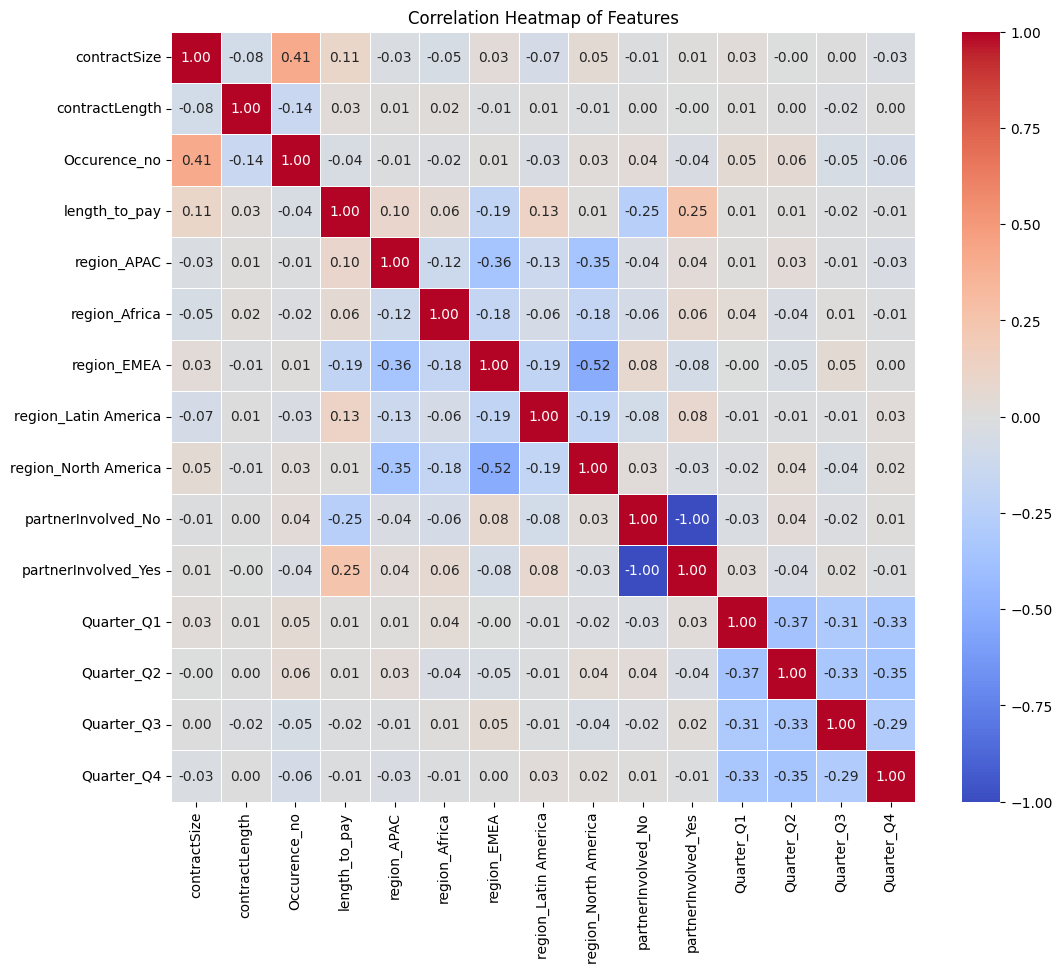

In [71]:
plt.figure(figsize=(12, 10))
sns.heatmap(corr, annot=True, cmap='coolwarm', fmt=".2f", linewidths=.5)
plt.title('Correlation Heatmap of Features')
plt.show()

## Summary of Data insights and Feature Derivation

>> The feature contract expiry date is determined by adding contract length to contract expiry date.

>> Customers whose contract expiry date is after Q4 2021 is out of the scope due to requirements of the assessment.

>> The only column that has null values is payment column, and these null values are assigned to records which have contact expiry date after Q4 2021 therefore these columns are not of concern because only customers with contact expiry date between Q3 and Q4 2021 need to be evaluated.

>> Feature length to pay is derived by subtracting closing date column from payment date column, this feature gives the number of days a customer took after the contract was finalized to make payment in number of days.

## Deriving Target Label for Churn

The dataset does not contain any information regarding customer churn therefore it needs to be derived based on closing date and the derived column contract expiry date.

>> Customers, determined by accountid, who sign new contract (For example: Occurrence number 2 or more) do so one day before or on the day of contract expiry date of previous contract, this is determined by the gap between closing date of new contract and the contract expiry date of the previous contract.

>> The function gap_between_deal assigns the number of days between the closing date of current contract and the expiry date of previous contract. This shows that customers who sign new contract do so one day before or on the date of expiration of previous contract.

>> The max closing date is June - 30 – 2021 there is no information after this date that can be used to determine if the customer signs a new contract or not that’s why this date is considered as present day.

Based on these analyses function determine_churn is used to determine if the contract is renewed, not renewed, or it is unknown if the customer will renew a new contract or not.


# 3. Supervised learning

In [72]:
# train and validation set split.
X_train, X_test, y_train, y_test = train_test_split(traindataset[traindataset.columns.difference(["is_renewal"])], traindataset['is_renewal'],stratify=traindataset['is_renewal'], test_size=0.15, random_state=42)

In [73]:
y_train.value_counts()

,count
is_renewal,
renewed,3932
not renewed,609


In [74]:
y_test.value_counts()

,count
is_renewal,
renewed,694
not renewed,108


In [75]:
# Dispplaying the training data
X_train.loc[:, ~X_train.columns.isin(removal_cls)]

,Occurence_no,Quarter_Q1,Quarter_Q2,Quarter_Q3,Quarter_Q4,contractLength,contractSize,length_to_pay,partnerInvolved_No,partnerInvolved_Yes,region_APAC,region_Africa,region_EMEA,region_Latin America,region_North America
2530,3,True,False,False,False,2,257.0,89.0,True,False,False,False,False,False,True
1301,3,False,False,True,False,1,135.0,101.0,True,False,False,False,False,False,True
1517,1,False,False,False,True,1,60.0,97.0,True,False,False,False,True,False,False
3641,1,True,False,False,False,2,115.0,81.0,True,False,False,False,False,False,True
802,1,False,False,True,False,3,140.0,65.0,True,False,False,False,True,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1378,2,False,False,True,False,3,227.0,99.0,True,False,False,False,False,False,True
1688,1,True,False,False,False,1,100.0,99.0,True,False,False,False,False,True,False
2652,3,True,False,False,False,2,416.0,86.0,True,False,False,False,True,False,False
1698,2,True,False,False,False,1,355.0,125.0,False,True,False,True,False,False,False


In [76]:
cls=list(X_train.loc[:, ~X_train.columns.isin(removal_cls)].columns)

In [77]:
# Using Logistic Classifier as the data is linear in nature and also gaussian bell curves. There is very little collinearity
logisticRegr = LogisticRegression(class_weight='balanced', solver='liblinear')
logisticRegr.fit(X_train.loc[:, ~X_train.columns.isin(removal_cls)], y_train)

LogisticRegression(class_weight='balanced', solver='liblinear')

In [78]:
# Validating the model
y_pred=logisticRegr.predict(X_test.loc[:, ~X_test.columns.isin(removal_cls)])

In [79]:
# Classificarion report: Recall of Not renwed is most important
print(classification_report(y_test, y_pred, target_names=logisticRegr.classes_))

              precision    recall  f1-score   support

 not renewed       0.22      0.66      0.33       108
     renewed       0.92      0.63      0.75       694

    accuracy                           0.63       802
   macro avg       0.57      0.64      0.54       802
weighted avg       0.83      0.63      0.69       802



In [80]:
# Now try a non linear algorithm
rf = RandomForestClassifier(class_weight='balanced')
rf.fit(X_train.loc[:, ~X_train.columns.isin(removal_cls)], y_train)
# Validating the model
y_pred=rf.predict(X_test.loc[:, ~X_test.columns.isin(removal_cls)])
print(classification_report(y_test, y_pred, target_names=logisticRegr.classes_))

              precision    recall  f1-score   support

 not renewed       0.24      0.05      0.08       108
     renewed       0.87      0.98      0.92       694

    accuracy                           0.85       802
   macro avg       0.55      0.51      0.50       802
weighted avg       0.78      0.85      0.81       802



In [81]:
# Dropping this column as it has all data labeled as unknown
testdataset.drop(columns=['is_renewal'],inplace=True)

/tmp/ipython-input-3046595828.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  testdataset.drop(columns=['is_renewal'],inplace=True)


In [82]:
testdataset.head(3)

,closingDate,contractSize,contractLength,paymentDate,accountID,Occurence_no,contract_expiry_date,length_to_pay,region_APAC,region_Africa,region_EMEA,region_Latin America,region_North America,partnerInvolved_No,partnerInvolved_Yes,Quarter_Q1,Quarter_Q2,Quarter_Q3,Quarter_Q4
4150,2018-07-01,148.0,3,2018-10-20,02k5gq,3,2021-07-01,111.0,True,False,False,False,False,False,True,False,False,True,False
4152,2018-07-01,257.0,3,2018-10-05,am5nm2,3,2021-07-01,96.0,True,False,False,False,False,False,True,False,False,True,False
4154,2018-07-02,128.0,3,2018-10-10,e0bgqm,3,2021-07-02,100.0,False,False,False,False,True,True,False,False,False,True,False


In [83]:
#Predicting on testdataset: Predicting on contracts which expires after the max closing date.
testdataset['is_renewal']=logisticRegr.predict(testdataset.loc[:, ~testdataset.columns.isin(removal_cls)][cls])

/tmp/ipython-input-2796753880.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  testdataset['is_renewal']=logisticRegr.predict(testdataset.loc[:, ~testdataset.columns.isin(removal_cls)][cls])


In [84]:
# knowing the order of classes
logisticRegr.classes_

array(['not renewed', 'renewed'], dtype=object)

In [85]:
# extracting the probabilities of renewal and not renewal
testdataset[['prob_not_renewed','renewed']]=logisticRegr.predict_proba(testdataset.loc[:, ~testdataset.columns.isin(removal_cls)][cls])

/tmp/ipython-input-3916390589.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  testdataset[['prob_not_renewed','renewed']]=logisticRegr.predict_proba(testdataset.loc[:, ~testdataset.columns.isin(removal_cls)][cls])
/tmp/ipython-input-3916390589.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  testdataset[['prob_not_renewed','renewed']]=logisticRegr.predict_proba(testdataset.loc[:, ~testdataset.columns.isin(removal_cls)][cls])


## Summary of supervised learning
The training, test, and prediction set are created; If the closing date is before present day, June- 30- 2021, then the record is in training set and if the record is between Q3 and Q4 2021 then the record is in prediction set because the churn is unknown. The records with contact expiry date after Q4 2021 are out of scope.

All the categorical columns are one hot encoded and Logistic regression algorithm is trained and then tested on testing set; the result Is “descent” for a baseline model.

In addition, a non linear model random forrest was tested however the performance was worst then the baseline model. Therefore the churn in testing set is predicted using baseline model.


# 4. Unsupervised Learning

From supervised learning we know which customers are going to churn however usually in a business setting the most important part is knowing what to do with these customers whether these customers should be offered promotion curated to their specific need, new product, or a different marketing strategy or simply to allocate resource to the high value customers. This is where unsupervised learning is useful, clustring can be used to find different segments of customers and their behavior.

In [86]:
testdataset['is_renewal'].value_counts()

,count
is_renewal,
renewed,460
not renewed,156


In [87]:
testdataset['istest']='Yes'

/tmp/ipython-input-2949112298.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  testdataset['istest']='Yes'


In [88]:
traindataset['is_renewal'].value_counts()

,count
is_renewal,
renewed,4626
not renewed,717


In [89]:
traindataset['istest']='No'

/tmp/ipython-input-2685310535.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  traindataset['istest']='No'


In [90]:
# Concatenating the train and test data so that all contracts which expires untill 2021 Dec 31st are together
wholedf=pd.concat([traindataset,testdataset])

In [91]:
wholedf.shape

(5959, 23)

In [92]:
wholedf.head(3)

,closingDate,contractSize,contractLength,paymentDate,accountID,Occurence_no,contract_expiry_date,length_to_pay,is_renewal,region_APAC,...,region_North America,partnerInvolved_No,partnerInvolved_Yes,Quarter_Q1,Quarter_Q2,Quarter_Q3,Quarter_Q4,istest,prob_not_renewed,renewed
0,2013-01-01,90.0,2,2013-03-28,julh8a,1,2015-01-01,86.0,renewed,False,...,True,True,False,True,False,False,False,No,NaN,NaN
1,2013-01-01,195.0,1,2013-04-21,ujmvzq,1,2014-01-01,110.0,renewed,True,...,False,True,False,True,False,False,False,No,NaN,NaN
2,2013-01-01,110.0,2,2013-03-23,0ar1mc,1,2015-01-01,81.0,renewed,False,...,False,True,False,True,False,False,False,No,NaN,NaN


In [93]:
wholedf.columns

Index(['closingDate', 'contractSize', 'contractLength', 'paymentDate',
       'accountID', 'Occurence_no', 'contract_expiry_date', 'length_to_pay',
       'is_renewal', 'region_APAC', 'region_Africa', 'region_EMEA',
       'region_Latin America', 'region_North America', 'partnerInvolved_No',
       'partnerInvolved_Yes', 'Quarter_Q1', 'Quarter_Q2', 'Quarter_Q3',
       'Quarter_Q4', 'istest', 'prob_not_renewed', 'renewed'],
      dtype='object')

In [94]:
#Removing one hot encoded variables as there is no need any more and constructing the quarter feature.
wholedf.drop(columns=['region_APAC', 'region_Africa', 'region_EMEA',\
       'region_Latin America', 'region_North America', 'partnerInvolved_No',\
       'partnerInvolved_Yes', 'Quarter_Q1', 'Quarter_Q2', 'Quarter_Q3',\
       'Quarter_Q4'],inplace=True)
wholedf['Quarter']=wholedf['closingDate'].dt.quarter
wholedf.head(2)

,closingDate,contractSize,contractLength,paymentDate,accountID,Occurence_no,contract_expiry_date,length_to_pay,is_renewal,istest,prob_not_renewed,renewed,Quarter
0,2013-01-01,90.0,2,2013-03-28,julh8a,1,2015-01-01,86.0,renewed,No,NaN,NaN,1
1,2013-01-01,195.0,1,2013-04-21,ujmvzq,1,2014-01-01,110.0,renewed,No,NaN,NaN,1


In [95]:
#Performing grouping to perform further operations at customer level
gdf=wholedf[['contractSize','contractLength','accountID','Occurence_no','length_to_pay','Quarter']]
gdf['Quarter']='Q'+gdf['Quarter'].astype(str)
resdf=gdf.groupby('accountID',as_index=False).agg({'contractSize':'mean','contractLength':'mean','Occurence_no':'max','length_to_pay':'mean','Quarter':pd.Series.mode})

/tmp/ipython-input-1238108637.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  gdf['Quarter']='Q'+gdf['Quarter'].astype(str)


In [96]:
resdf

,accountID,contractSize,contractLength,Occurence_no,length_to_pay,Quarter
0,00dkoj,255.25,1.75,4,86.25,Q2
1,00fcnj,103.50,2.00,2,119.50,Q1
2,00t9nx,320.00,3.00,1,83.00,Q4
3,010sfv,167.50,1.75,4,56.25,Q1
4,01ewog,106.00,2.50,2,82.50,Q1
...,...,...,...,...,...,...
2839,zycnd0,50.00,3.00,1,67.00,Q1
2840,zynk6x,272.50,1.50,2,132.50,Q4
2841,zz5bex,70.00,2.00,1,96.00,Q1
2842,zzn203,265.00,3.00,1,126.00,Q3


In [97]:
#Merging with customers data to get the region and partner involved features
resdf=pd.merge(resdf,adf,on='accountID',how='inner')

In [98]:
resdf

,accountID,contractSize,contractLength,Occurence_no,length_to_pay,Quarter,region,partnerInvolved
0,00dkoj,255.25,1.75,4,86.25,Q2,North America,No
1,00fcnj,103.50,2.00,2,119.50,Q1,North America,Yes
2,00t9nx,320.00,3.00,1,83.00,Q4,North America,No
3,010sfv,167.50,1.75,4,56.25,Q1,EMEA,No
4,01ewog,106.00,2.50,2,82.50,Q1,EMEA,No
...,...,...,...,...,...,...,...,...
2839,zycnd0,50.00,3.00,1,67.00,Q1,Latin America,No
2840,zynk6x,272.50,1.50,2,132.50,Q4,EMEA,No
2841,zz5bex,70.00,2.00,1,96.00,Q1,EMEA,No
2842,zzn203,265.00,3.00,1,126.00,Q3,North America,No


In [99]:
#Copying dataframe without account id for performing clustering analysis and segmenting the customers.
p=resdf.loc[:, resdf.columns != 'accountID']

In [100]:
# if number of each customer's contract  is even then at the time of grouping the output of mode will be 2 elements.
# So  extracting the first element of the mode result
def quarter_prob(quar):

  if isinstance(quar,np.ndarray):
    return quar[0]
  else:
    return quar


In [101]:
p['final_Quarter']=p['Quarter'].apply(quarter_prob)

In [102]:
# Computing gower's distance metric to determine how different records are. Gowers distance can handle categorical variables too
# No Quarter(because the clustering is getting biased to quarters) and
# No region in baseline model.
import gower
gm=gower.gower_matrix(p[['contractSize','contractLength','Occurence_no','length_to_pay','partnerInvolved']])

In [116]:
#Using K-Mediods clustering to segement the customers into clusters and identifying the patterns.
#PAM Clustering has been choosen as it works well for smaller datasets and works well for categorical variables.
#PAM also handles outliers and noise well
gower_clusterer_medoids = KMedoids(n_clusters=3, metric='precomputed',
                           method='pam', init='build',
                           max_iter=300, random_state=32).fit(gm)

In [117]:
# Overall silhouette score
labels = gower_clusterer_medoids.labels_
overall_sil = silhouette_score(gm, labels, metric='precomputed')
print("Overall Silhouette Score:", overall_sil)

Overall Silhouette Score: 0.37456545


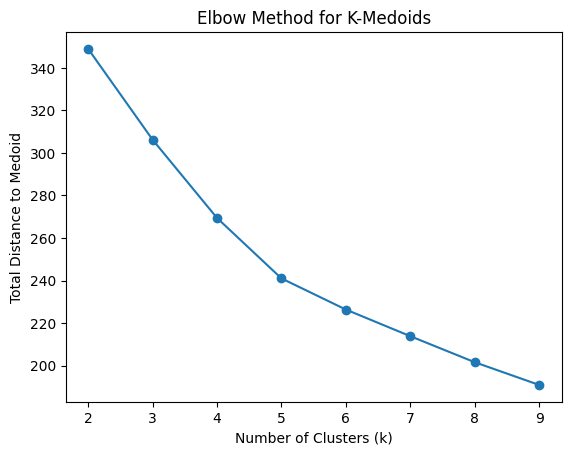

In [108]:
wcss = []  # Within-Cluster Sum of Distances

for k in range(2, 10):
    kmed = KMedoids(
        n_clusters=k,
        metric="precomputed",
        method="pam",
        init="build",
        max_iter=300,
        random_state=32
    ).fit(gm)

    # compute total distance of each point to its cluster medoid
    total_dist = 0
    for cluster_id in range(k):
        medoid_idx = kmed.medoid_indices_[cluster_id]
        total_dist += gm[kmed.labels_ == cluster_id, medoid_idx].sum()

    wcss.append(total_dist)

# Plot elbow
plt.plot(range(2, 10), wcss, marker='o')
plt.xlabel("Number of Clusters (k)")
plt.ylabel("Total Distance to Medoid")
plt.title("Elbow Method for K-Medoids")
plt.show()

In [145]:
from sklearn.cluster import AgglomerativeClustering
# Example with 3 clusters; you can vary n_clusters
agg = AgglomerativeClustering(
    n_clusters=5,
    metric='precomputed',   # works with distance matrix
    linkage='average'         # 'average' or 'complete' often good with Gower
)
agg_labels = agg.fit_predict(gm)

# overall silhouette
agg_sil_overall = silhouette_score(gm, agg_labels, metric='precomputed')
print("Overall silhouette score (Agglomerative, k=5):", agg_sil_overall)


Overall silhouette score (Agglomerative, k=5): 0.28534046


In [146]:
np.unique(labels)

array([0, 1, 2])

In [127]:
# Using dimensionality reduction to visualise cluster plots
# Reducing gowers distance to 2 axis
umap_embeddings = umap.UMAP(random_state=42, n_components=2).fit_transform(gm)
gower_data=p[['contractSize','contractLength','Occurence_no','length_to_pay','partnerInvolved']].copy()
gower_data['x'] = umap_embeddings[:,0]
gower_data['y'] = umap_embeddings[:,1]

/usr/local/lib/python3.12/dist-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


In [147]:
#Assigning Cluster labels to dataset.
gower_data["preds"] = labels
gower_data["preds"] = gower_data["preds"].apply(str)

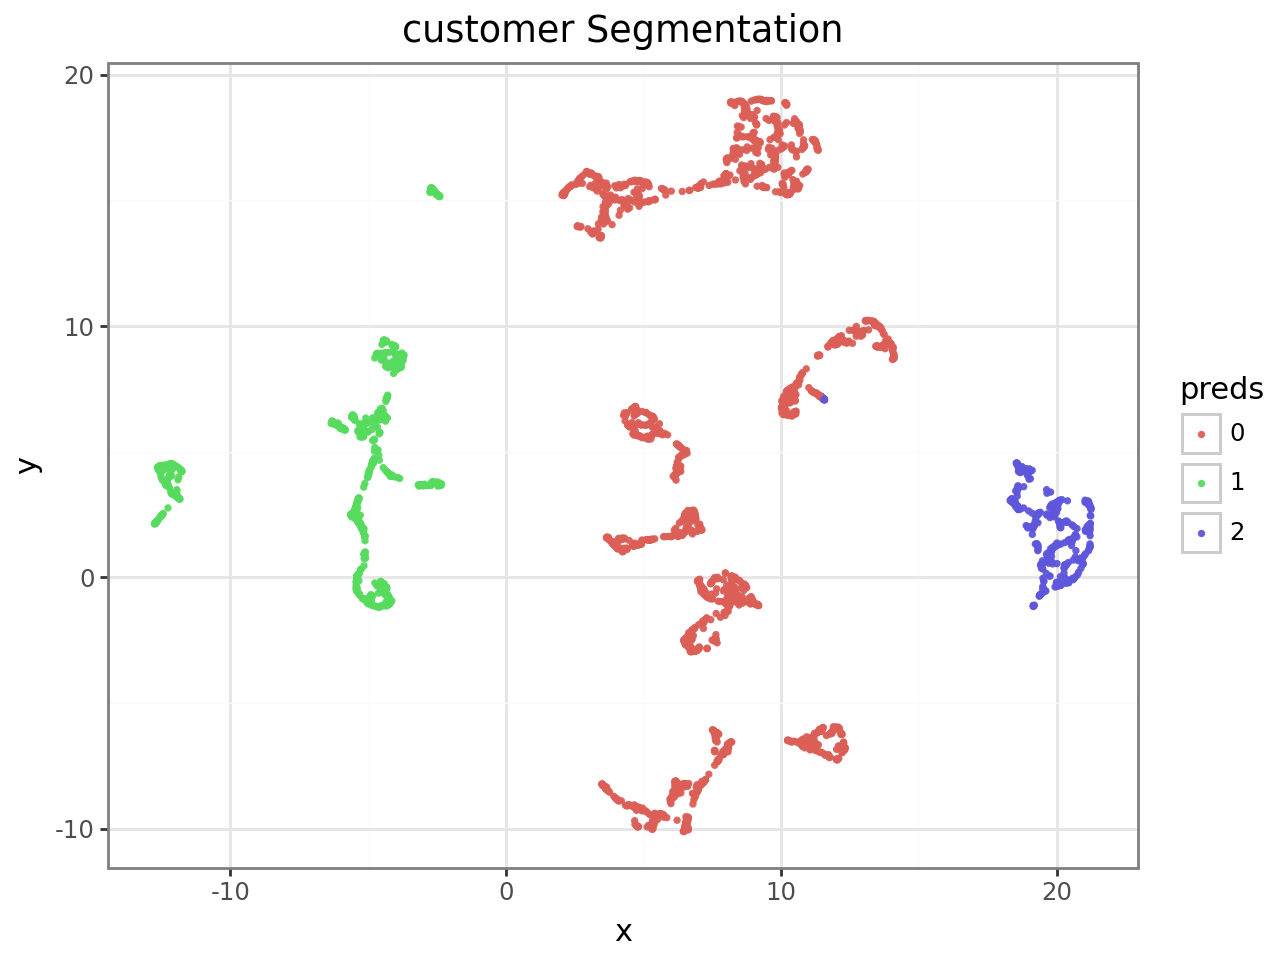

In [149]:
# Visualizing clusters.
p2 = (p9.ggplot(gower_data, p9.aes(x='x', y='y', fill='preds', color='preds'))
      + p9.geom_point(alpha=0.9, size=0.5)
      + p9.ggtitle('customer Segmentation')
      + p9.theme_bw())
p2

In [150]:
#Assigning Customers to clustered labeled data. To identify which customer falls in which customer cluster.
p['accountID']=resdf['accountID']
p['cluster_labels']=gower_data["preds"].apply(str)

In [151]:
p[p['cluster_labels']=="1"]

,contractSize,contractLength,Occurence_no,length_to_pay,Quarter,region,partnerInvolved,final_Quarter,accountID,cluster_labels
1,103.500000,2.000000,2,119.50,Q1,North America,Yes,Q1,00fcnj,1
7,136.666667,2.666667,3,118.00,Q3,APAC,Yes,Q3,02k5gq,1
11,65.000000,3.000000,1,83.00,Q4,EMEA,Yes,Q4,048oq7,1
12,180.000000,2.000000,1,101.00,Q1,North America,Yes,Q1,05jqaf,1
17,140.000000,2.000000,1,92.00,Q2,North America,Yes,Q2,07egvp,1
...,...,...,...,...,...,...,...,...,...,...
2816,161.750000,1.750000,4,119.25,Q3,Latin America,Yes,Q3,zq0n9r,1
2823,257.500000,2.000000,2,148.50,Q2,APAC,Yes,Q2,zsyrln,1
2826,70.000000,1.000000,1,148.00,Q2,EMEA,Yes,Q2,zu7vr3,1
2829,230.000000,2.500000,2,109.00,Q4,North America,Yes,Q4,zuk30o,1


In [152]:
# visualizing clusters:
vdf=p[['contractSize','contractLength','Occurence_no','length_to_pay','cluster_labels']]
vdf1=vdf[vdf['cluster_labels']=="0"]
vdf2=vdf[vdf['cluster_labels']=="1"]
vdf3=vdf[vdf['cluster_labels']=="2"]
categories=['contractSize','contractLength','Occurence_no','length_to_pay']
aggval1=[vdf1['contractSize'].mean()/100,vdf1['contractLength'].mean(),vdf1['Occurence_no'].mode().iloc[0],vdf1['length_to_pay'].mean()/30]
aggval2=[vdf2['contractSize'].mean()/100,vdf2['contractLength'].mean(),vdf2['Occurence_no'].mode().iloc[0],vdf2['length_to_pay'].mean()/30]
aggval3=[vdf3['contractSize'].mean()/100,vdf3['contractLength'].mean(),vdf3['Occurence_no'].mode().iloc[0],vdf3['length_to_pay'].mean()/30]

In [154]:
fig = go.Figure()

fig.add_trace(go.Scatterpolar(
      r=aggval1,
      theta=categories,
      fill='toself',
      name='Cluster 1'
))
fig.add_trace(go.Scatterpolar(
      r=aggval2,
      theta=categories,
      fill='toself',
      name='Cluster 2'
))
fig.add_trace(go.Scatterpolar(
      r=aggval3,
      theta=categories,
      fill='toself',
      name='Cluster 3'
))
fig.update_layout(
  polar=dict(
    radialaxis=dict(
      visible=True,
      range=[0, 4]
    )),
  showlegend=True
)

fig.show()

In [155]:
plotly.offline.plot(fig, auto_open=False)

'temp-plot.html'

## Summary Unsupervised learning

Once the supervised learning model identified which customers are likely to churn, the next step was to understand how these customers differ in behavior so that the business can take meaningful action. For this purpose, unsupervised learning—specifically clustering—was applied to uncover customer segments.

Before clustering, all one-hot encoded columns were removed because the chosen distance metric, Gower Distance, naturally handles mixed data types without requiring dummy variables. A new quarter feature was also derived from the closing date to support temporal interpretation, though it was later excluded from the clustering itself.

### Gower Distance

Gower Distance is a similarity measure designed for datasets containing both numerical and categorical variables. It scales each feature between 0 and 1, computes pairwise similarity for each variable type, and then averages the results.
This makes it ideal for business datasets where fields such as contract size (numeric) and partner involved (categorical) coexist.

Gower distance was applied to the following features:

>> contractsize

>> ContractLength

>> Occurrence number

>> length_to_pay

>> PartnerInvolved

The features quarter and region were excluded from clustering.

### Clustering Methods and Evaluation

Two clustering approaches were tested:

>> K-Medoids Clustering

>> Agglomerative Clustering

Because clustering requires a way to judge quality, the silhouette score was used.

### Silhouette Score

The silhouette score measures how well each data point fits within its assigned cluster compared to other clusters.
It ranges from -1 to 1, where:

>> 1 → Points are well-matched to their cluster and far from others

>> 0 → Clusters overlap (weak structure)

>>Negative values → Points may be misclassified

>>Higher values indicate better-defined clusters.

K-medoids produced a higher silhouette score than agglomerative clustering, indicating clearer and more cohesive cluster separation. The elbow method was also used to identify the optimal number of clusters, suggesting that five clusters would be ideal. However, to keep business interpretation simple and actionable, three clusters were ultimately chosen.

### K-Medoids Clustering

K-medoids is similar to k-means but is more robust, particularly when working with non-Euclidean distances such as Gower. Instead of using a mean value as a centroid, each cluster is represented by an actual data point called a medoid, making the approach more stable and suitable for mixed-type business data.

### Visualization Using UMAP

To visualize the clusters, UMAP (Uniform Manifold Approximation and Projection) was applied to the Gower distance matrix. UMAP is a nonlinear dimensionality reduction technique that preserves both local and global structure, allowing complex high-dimensional relationships to be displayed clearly in 2D space.

The UMAP 2D plot revealed distinct and well-separated clusters, confirming the quality of the segmentation. In addition, radial charts were created for each cluster to visualize customer behavior patterns across the most important features.


### Clustering Insights

Observing the clusters in radial plot, the customer patterns can be deduced as following:

- Cluster 1 has customers who frequently renew the contracts and their contract value (size) is relatively high therefore this cluster contain high value customers whose contracts are usually long term and high value.


- Cluster 3 has the highest contract length but the occurrence and the size are the least. Everything considered these customers are second in priority.


- Cluster 2 and cluster 1 have similar average contract lengths however these customers take relatively longer time to pay when compared to other clusters and have the least occurrence. Customers in this cluster have the least priority.


- Order of priority of clusters based on above Insights: [ C1, C3, C2]






# 5. Finalizing the results

In [156]:
# Extracting only the customers whose contracts expiry is between Q3 amd Q4 of 2021
finaldf = pd.merge(p,testdataset[['accountID','is_renewal','prob_not_renewed','renewed']],on='accountID',how='inner')

In [157]:
finaldf

,contractSize,contractLength,Occurence_no,length_to_pay,Quarter,region,partnerInvolved,final_Quarter,accountID,cluster_labels,is_renewal,prob_not_renewed,renewed
0,320.000000,3.000000,1,83.0,Q4,North America,No,Q4,00t9nx,2,renewed,0.441846,0.558154
1,147.000000,1.750000,4,75.0,Q3,North America,No,Q3,01kumi,0,renewed,0.090186,0.909814
2,136.666667,2.666667,3,118.0,Q3,APAC,Yes,Q3,02k5gq,1,renewed,0.344038,0.655962
3,140.800000,1.400000,5,101.2,Q4,North America,No,Q4,07x5kz,0,renewed,0.077112,0.922888
4,131.000000,2.000000,2,75.0,Q3,EMEA,No,Q3,08e5y5,0,renewed,0.281595,0.718405
...,...,...,...,...,...,...,...,...,...,...,...,...,...
611,122.500000,2.000000,2,97.0,Q3,APAC,No,Q3,zqjvr0,0,renewed,0.377264,0.622736
612,130.000000,2.000000,3,76.0,Q4,North America,No,Q4,zs7uky,0,renewed,0.182773,0.817227
613,270.000000,2.000000,1,79.0,Q4,North America,No,Q4,zuftet,0,renewed,0.430988,0.569012
614,150.000000,2.000000,1,74.0,Q4,Latin America,No,Q4,zw9ffc,0,not renewed,0.567158,0.432842


In [158]:
#Diving into Renewed and not renewed
nr = finaldf[finaldf['is_renewal']=='not renewed']
r = finaldf[finaldf['is_renewal']=='renewed']

In [159]:
nr

,contractSize,contractLength,Occurence_no,length_to_pay,Quarter,region,partnerInvolved,final_Quarter,accountID,cluster_labels,is_renewal,prob_not_renewed,renewed
9,70.0,2.0,1,82.0,Q3,APAC,Yes,Q3,0csile,1,not renewed,0.520971,0.479029
15,110.0,2.0,1,89.0,Q4,North America,Yes,Q4,0n30fj,1,not renewed,0.534532,0.465468
20,115.0,3.0,1,116.0,Q3,Africa,Yes,Q3,0tb1t6,1,not renewed,0.760236,0.239764
23,130.0,2.0,1,146.0,Q3,Africa,No,Q3,0uq34p,0,not renewed,0.849979,0.150021
25,85.0,2.0,1,120.0,Q4,EMEA,No,Q4,0y1g60,0,not renewed,0.705804,0.294196
...,...,...,...,...,...,...,...,...,...,...,...,...,...
598,110.0,2.0,1,105.0,Q4,EMEA,No,Q4,ywkfy5,0,not renewed,0.627422,0.372578
602,118.5,2.0,2,139.5,Q3,EMEA,Yes,Q3,zahdxw,1,not renewed,0.745978,0.254022
609,115.0,3.0,1,114.0,Q3,APAC,No,Q3,zl7mrs,2,not renewed,0.650390,0.349610
614,150.0,2.0,1,74.0,Q4,Latin America,No,Q4,zw9ffc,0,not renewed,0.567158,0.432842


In [160]:
# Dividing further into Cluster level
nr1=nr[nr['cluster_labels']=="0"]
nr2=nr[nr['cluster_labels']=="1"]
nr3=nr[nr['cluster_labels']=="2"]
r1=r[r['cluster_labels']=="0"]
r2=r[r['cluster_labels']=="1"]
r3=r[r['cluster_labels']=="2"]

In [161]:
#Sorting not renewed data by the probability in descending order. As these are the customers who are most probable to get churned.
nr1 = nr1.sort_values(by='prob_not_renewed', ignore_index=True,ascending=False)
nr2 = nr2.sort_values(by='prob_not_renewed', ignore_index=True,ascending=False)
nr3 = nr3.sort_values(by='prob_not_renewed', ignore_index=True,ascending=False)
#Sorting the renewed data by the probability in ascending order. Sorting in ascending order as these customers have low probaility of churn.
r1 = r1.sort_values(by='renewed', ignore_index=True,ascending=True)
r2 = r2.sort_values(by='renewed', ignore_index=True,ascending=True)
r3 = r3.sort_values(by='renewed', ignore_index=True,ascending=True)

In [162]:
# Concatenating all the above dataframes
# The resulatant concatenation is the ranking of customers who are most concerned customers.
pd.concat([nr1,nr3,nr2,r1,r3,r2])

,contractSize,contractLength,Occurence_no,length_to_pay,Quarter,region,partnerInvolved,final_Quarter,accountID,cluster_labels,is_renewal,prob_not_renewed,renewed
0,130.000000,2.0,1,146.000000,Q3,Africa,No,Q3,0uq34p,0,not renewed,0.849979,0.150021
1,55.000000,2.0,1,118.000000,Q3,Latin America,No,Q3,lwn97d,0,not renewed,0.787650,0.212350
2,85.000000,2.0,1,133.000000,Q4,EMEA,No,Q4,bmmy34,0,not renewed,0.764806,0.235194
3,55.000000,2.0,1,127.000000,Q3,APAC,No,Q3,m4gesa,0,not renewed,0.726216,0.273784
4,85.000000,2.0,1,102.000000,Q3,Latin America,No,Q3,7gxckr,0,not renewed,0.717663,0.282337
...,...,...,...,...,...,...,...,...,...,...,...,...,...
66,157.200000,1.6,5,99.400000,Q1,EMEA,Yes,Q1,wl17gv,1,renewed,0.122770,0.877230
67,432.200000,1.6,5,108.800000,Q3,EMEA,Yes,Q3,nfqyvm,1,renewed,0.117361,0.882639
68,174.000000,1.2,5,100.200000,Q4,EMEA,Yes,Q4,qrzbfn,1,renewed,0.114979,0.885021
69,239.000000,1.4,5,91.600000,Q4,North America,Yes,Q4,btfgrb,1,renewed,0.055999,0.944001


In [163]:
fdf=pd.concat([nr1,nr3,nr2,r1,r3,r2])

In [164]:
fdf.to_csv("churn_analyses_results1.csv")

# Conclusion

This project demonstrates a complete end-to-end approach for combining supervised and unsupervised learning to solve a real-world business problem: identifying customers likely to churn and determining how to act on that information. First, supervised learning was applied to predict which customers are at risk of churn and to estimate their likelihood. Since the dataset did not include a churn label, the churn outcome had to be derived, closely reflecting real-life scenarios where analysts must infer business outcomes from available data.

Next, unsupervised learning was used to cluster customers into meaningful behavioral segments. These clusters allowed the business to understand the value, engagement pattern, and renewal behavior of different types of customers. Once clusters were identified, customers within each cluster were ranked by their predicted churn probability, providing a structured and actionable prioritization framework.

This integrated approach helps the company understand both who is likely to churn and how to treat different customer groups based on their segment characteristics. While the project establishes a strong baseline, additional improvements remain possible. Further modeling experiments with more advanced supervised algorithms, optimized feature engineering, and additional clustering methods could enhance accuracy and deepen customer insights.

Overall, this project effectively illustrates how supervised and unsupervised learning techniques can work together to guide real business decisions and how analytical reasoning is required when churn definitions are not explicitly provided in the data.

